In [1]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
data = loadmat("data/allFaces.mat")

In [2]:
X = data['faces'].T

# 構建標籤
label_counts = [64, 62, 64, 64, 62, 64, 64, 64, 64, 64, 60, 59, 60, 63, 62, 63, 63,
                64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
                64, 64, 64, 64]
labels = np.repeat(np.arange(len(label_counts)), label_counts)

# 將標籤添加到X數組中
X_labeled = np.c_[X, labels]

# 將X_labeled轉換為dataframe
df = pd.DataFrame(X_labeled, columns=[f"{i}" for i in range(X.shape[1])] + ["label"])
X = df.drop('label', axis=1)
y = df['label']

In [3]:
#預處理
X = np.array(df.iloc[:, :-1]) # 2410 x 32256
y = np.array(df.iloc[:, -1]) 
X.shape[1]

32256

In [4]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) # deafult test_size=0.25
 
# standaredize (may not be necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
 
# convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_train = X_train.reshape(-1, 1,168,192) # convert to N x 1 x 28 x 28 for CNN (一小張黑白圖片的大小為168x192)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
X_test = X_test.reshape(-1, 1, 168, 192) # N x 1 x 28 x 28 

 
# check shapes of data
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
 
# create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train.shape: torch.Size([1928, 1, 168, 192])
y_train.shape: torch.Size([1928])
X_test.shape: torch.Size([482, 1, 168, 192])
y_test.shape: torch.Size([482])


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
         
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input channel, 6 output channels, 5x5 square convolution ->(N,6,24,24)-pool->(N,6,12,12)
        self.conv2 = nn.Conv2d(6, 16, 5) # 接著前面的output, 6 input channel, 16 output channels, 5x5 square convolution ->(N,16,8,8)-pool->(N,16,4,4)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 45 * 39, 128)  # 接著前面的output, 4*4 from image dimension 
        self.fc2 = nn.Linear(128, 38)
        #self.fc3 = nn.Linear(84, 38) # 10 output classes
 
    def forward(self, x):
         
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x
 
 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
 
net = Net().to(device)
print(net)

Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28080, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=38, bias=True)
)


(1, 38)
tensor([[ 0.0299, -0.0018,  0.0531, -0.1225, -0.0139,  0.1064,  0.0150, -0.0457,
         -0.0933, -0.0012, -0.0641,  0.0115,  0.0226, -0.0716,  0.0800, -0.0130,
          0.0929,  0.0825,  0.0913,  0.0406, -0.0421, -0.0523,  0.0590, -0.0354,
          0.0317,  0.0174,  0.0055,  0.1087,  0.0973, -0.0916,  0.0355, -0.0766,
          0.0068,  0.0663, -0.0256, -0.0031, -0.1235, -0.1121]])
tensor([[27]])
[[ 0.02987005 -0.0017812   0.05309274 -0.12251844 -0.01393669  0.1064047
   0.01500389 -0.04569454 -0.09327935 -0.00115565 -0.06410941  0.0115352
   0.02260923 -0.07161094  0.08004699 -0.01303969  0.09294592  0.08253632
   0.09134167  0.04061099 -0.04211718 -0.05229446  0.05899157 -0.03536116
   0.03168344  0.01741065  0.00553087  0.10869955  0.09726221 -0.09155995
   0.03545882 -0.07656097  0.00683532  0.06630383 -0.02563678 -0.00305299
  -0.12350087 -0.11213265]]
torch.Size([16, 1, 168, 192])


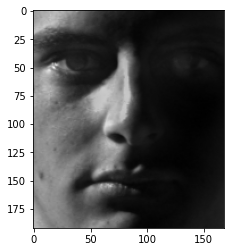

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


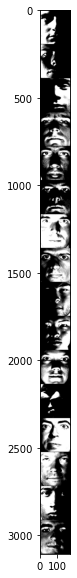

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
 
input = train_dataset[0][0].reshape(1, 1, 168, 192)
# 觀察 network 輸出結果
out = net(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())
 
# get some random training images
dataiter = iter(train_loader) # an iterable object
images, labels = next(dataiter) # get the next batch
print(images.shape)
 
# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (2, 1, 0))
plt.imshow(a_image_, cmap='gray')
plt.show()
 
# show a grid of images
montage = torchvision.utils.make_grid(images, nrow=16) # make a grid of images with 16 images per row
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(montage, (2, 1, 0)), cmap='gray')
plt.show()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net2.parameters(), lr = 0.01) 


In [8]:
epochs = 20
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        #print(data[1])
        #print(data[0])

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass

        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
 
print('Finished Training')

Finished Training


In [9]:
PATH = './yelaFace_net.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


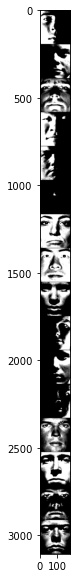

The predictions:
 {tensor([[27, 14, 17, 12,  6, 30, 13,  1, 23,  6, 23,  3, 18, 31, 28, 28]])}
Accuracy of the network on the 64 test images: 87.5 %


In [13]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
 
sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)
 
# print test images
nrow = 16 # number of images per row
montage = torchvision.utils.make_grid(images, nrow=nrow)
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(montage, (2, 1, 0)), cmap='gray')
plt.show()
 
# predict the labels
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // nrow, nrow)})
 
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the 64 test images: {100 * correct_rate} %')